# Singular value decomposition and Funk SVD from scratch

### Aims

- Explain the fundamentals of singular value decomposition (SVD).


- Demonstrate SVD with simple R code on a simple simulated matrix.


- Describe and explain the Funk SVD algorithm for sparse matrices.


- Demonstrate the Funk SVD algorithm using a simple simulated matrix and base R code.


Full credit and appreciation to the ['Matrix Factorization and Advanced Techniques'](https://www.coursera.org/learn/matrix-factorization?specialization=recommender-systems) Coursera course which proved invaluable.


### Load prerequisites

In [1]:

library(MASS)
library(ggplot2)
library(reshape2)
library(gridExtra)

set.seed(20190528)


Warning message:
“package ‘ggplot2’ was built under R version 3.5.2”

## Singular value decomposition

A matrix $R$ of dimensions $u$ x $i$ can be decomposed to:

$$ R = P \Sigma Q^{T} $$

Where $P$ denotes a $u$ x $k$ matrix, $Q$ denotes a $i$ x $k$ matrix and $\Sigma$ denotes a diagonal $k$ x $k$ matrix of the absolute values of the eigenvalues of $R$. Notably the diagonal elements of $\Sigma$ are ordered from large to small.    These $k$ elements can be defined as features that link the $u$ and $i$ components of $R$ together.

The computations for deriving $P$, $\Sigma$ and $Q$ are tedious but simple.

Let's simulate a simple matrix to carry out SVD.

### Example

Consider a hypothetical example of 10 users interacting with 6 items, for each interaction a value is returned.  This value can be regarded as some kind of review score.

In this example users can be defined into two types:


In [2]:

user.types <- c(rep(0, 5), rep(1, 5))


Items can be also be defined into two types:

In [3]:

item.types <- c(rep(0, 3), rep(1, 3))


We can then randomly generate a $u$ x $i$ matrix, where $u$ denotes the number of users and $i$ denotes the number of items, and $U$ and $I$ denote the vector of user types and item types respectively.  The value of $R_{ui}$ can then be conditional on $U$ and $I$.

$$ R_{ui} \mid U_u = 0 \cup I_i = 0 \sim N(0, \sigma^2) $$

$$ R_{ui} \mid U_u = 1 \cap I_i = 1 \sim N(1, \sigma^2) $$

Where $\sigma = 0.5$.

In [4]:

R <- matrix(rep(as.numeric(NA), 10 * 6), 10, 6)

for (u in 1:10) {
      
      for (i in 1:6) {
    
        # Populate elements of the matrix with conditional random normal
        
        R[u, i] <- round(rnorm(1, 0 + ((user.types[u] * item.types[i]) * 1), 0.5), 2)
    
        }
  
    }

rownames(R) <- paste0("User ", seq(1, 10, 1))
colnames(R) <- paste0("Item ", seq(1, 6, 1))


Let's visualise this:

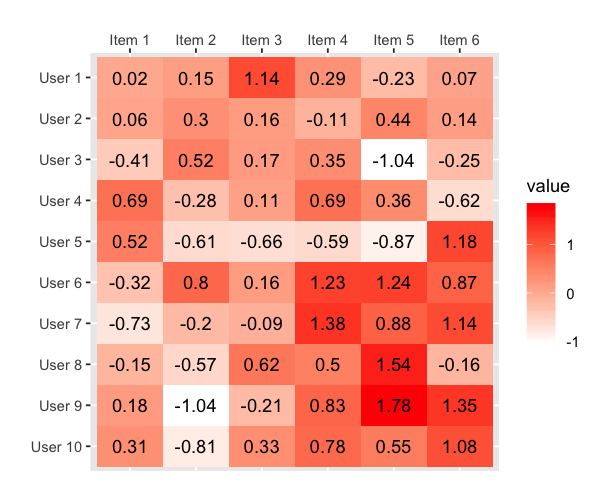

In [5]:

R.plot <- ggplot(melt(apply(t(R), 1, rev)), aes(x = Var2, y = Var1, fill = value)) + 
            geom_tile() +
              scale_fill_continuous(low = "white", high = "red") +
                  geom_text(aes(label = round(value, 2))) + xlab("") + ylab("") +
                      scale_x_discrete(position = "top")

options(repr.plot.width = 5, repr.plot.height = 4)

R.plot


It can be seen that for user type 1 and item type 1 elements the mean value is visibly higher.

Let's carry out a singular value decomposition, using the MASS package this is very easy in R:

In [6]:

SVD <- svd(R)


This returns a list item of three parts, representing $P$, $\Sigma$ and $Q$.

A $10$ x $6$ ($u$ x $k$) user-feature matrix:

In [7]:

P <- SVD$u

dim(P)


[1] 10  6

A $6$ x $6$ ($i$ x $k$) item-feature matrix: 

In [8]:

Q <- SVD$v

dim(Q)


[1] 6 6

A vector of length $6$ ($k$) of feature weights.  These are the diagonal elements of the $\Sigma$ matrix:

In [9]:

S <- SVD$d

length(S)


[1] 6

Let's reconstruct $R$ using the components of the SVD, it can be seen that they're identical: 

In [10]:
# Reconstruct R

R.tilde <- P %*% diag(S) %*% t(Q)

all.equal(sum(R.tilde), sum(R))


[1] TRUE

Very importantly the diagonal elements of $\Sigma$ are ordered from large to small:

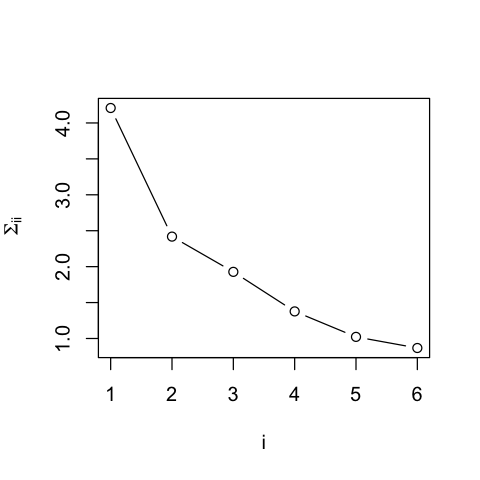

In [11]:

options(repr.plot.width = 4, repr.plot.height = 4)

plot(seq(1, 6, 1), S, type = "b", xlab = "i", ylab = bquote(~ Sigma[i][i]))


$R$ can be reconstructed using a truncated $\Sigma$ matrix of less than $k$ elements.  

Let's reconstruct $R$ using only the first 3 elements of $\Sigma$.

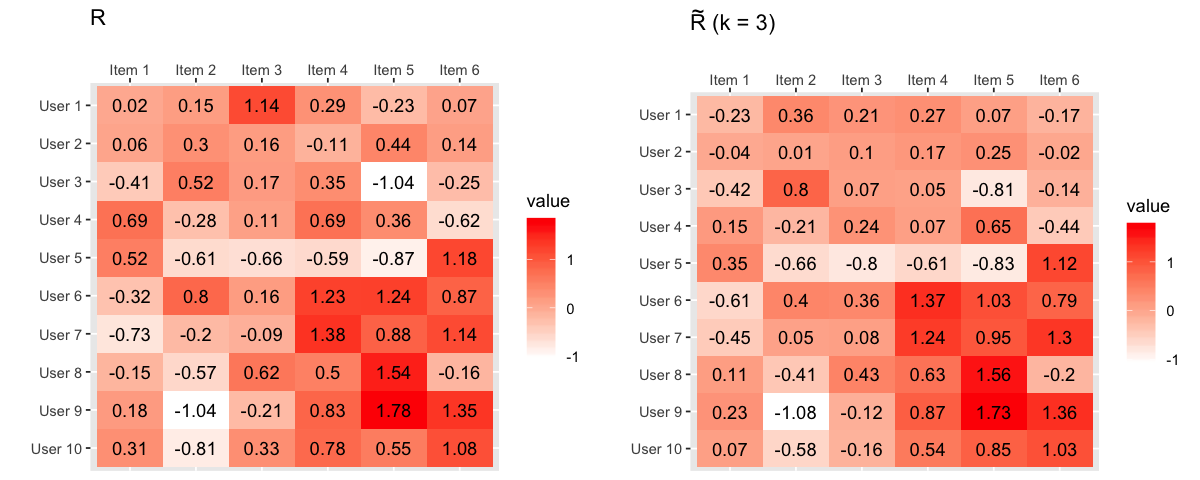

In [12]:

R.tilde3 <- P %*% diag(c(S[1:3], rep(0, 3))) %*% t(Q)

rownames(R.tilde3) <- paste0("User ", seq(1, 10, 1))
colnames(R.tilde3) <- paste0("Item ", seq(1, 6, 1))

# Plot R.tilde3

Rt.plot <- ggplot(melt(apply(t(R.tilde3), 1, rev)), aes(x = Var2, y = Var1, fill = value)) + 
                geom_tile() +
                    scale_fill_continuous(low = "white", high = "red") +
                      geom_text(aes(label = round(value, 2))) + xlab("") + ylab("") +
                          scale_x_discrete(position = "top")

options(repr.plot.width = 10, repr.plot.height = 4)

grid.arrange(R.plot + ggtitle("R"), 
             Rt.plot + ggtitle(expression(paste(tilde(R), " (k = 3)"))), nrow = 1)


Using only 3 features, the elements of $R$ are still estimated to reasonal accuracy.  

Calculating the sum of the squared error (SSE) for each set of $k$ features yields the following curve:

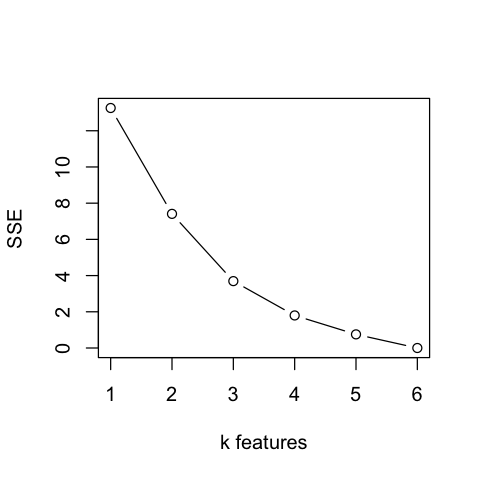

In [13]:

sse.seq <- rep(as.numeric(NA), 6)

for (k in 1:6) {
  
      Rt <- P %*% diag(c(S[1:k], rep(0, 6 - k))) %*% t(Q)
  
      sse.seq[k] <- sum((R - Rt)^2)
  
    }

options(repr.plot.width = 4, repr.plot.height = 4)

plot(seq(1, 6, 1), sse.seq, type = "b", xlab = "k features", ylab = "SSE",)


Calculating the null SSE:

In [14]:

sum((R - mean(R))^2)


[1] 27.23517

It can be seen that using only the first feature can describe roughly 50% of the variance in $R$ and that using the top 4 features can describe nealy all the variation in $R$.

### Conclusions

SVD underpins many dimension reduction methods, complex data can be described by a much smaller $k$ number of features, this reduces complex computations and can be used to infer hidden elements that are not normally apparent.

In the context of recommendation systems standard SVD often can not be used.  Why?

- Data is usually sparse, e.g. a Netflix user will have only seen a tiny proportion of the many 1000s of shows available to them.


- For very large matrices (millions of users x millions of items) the computations required to derive $P$, $\Sigma$ and $Q$ become far too computationally burdensome.


# Funk SVD

The [Funk SVD](https://sifter.org/~simon/journal/20061211.html) algorithm won the Netflix prize for beating the Netflix's existing algorithms at predicting user ratings of movies and tv-shows in it's catalogues.  

- Funk SVD can work with extremely sparse matrices.


- Funk SVD carries out an iterative training algorithm that can easily be applied to very larges matrices such as those seen in real-life user-item interaction data.

Next I'll go through the fundamentals of Funk SVD at a very high level and implement the algorithm using base R code on a small simulated example.


Funk SVD simplifies the SVD process by folding in $\Sigma$ into the $P$ and $Q$ matrices such that:

$$ R = PQ^T $$

Where $P$ denotes a $u$ x $k$ matrix and $Q$ denotes a $i$ x $k$ matrix.  Therefore $P$ denotes a user-feature matrix and $Q$ denotes an item feature matrix.

Estimation of $P$ and $Q$ is carried out using stochastic gradient descent (see below).  This can be demonstrated by first simulating a sparse matrix.


### Create a sparse matrix

First let's create a sparse matrix of $u$ x $i$ user-item interaction data:


In [15]:
# Define total users and total items

tu <- 50 # Total users

ti <- 10 # Total items 


As in the SVD example, bucket users and items into two type.  Then create a 'types' matrix for convenience, this a matrix of 0's and 1's: 

In [16]:

user.types <- c(rep(0, floor((2/3)*tu)), rep(1, ceiling((1/3)*tu)))

item.types <- c(rep(0, floor((1/2)*ti)), rep(1, ceiling((1/2)*ti)))

Tm <- matrix(rep(as.numeric(NA), tu * ti), tu, ti)

for (u in 1:tu) {
  
  for (i in 1:ti) {
    
    # Populate elements of the matrix with conditional random normal
    
    Tm[u, i] <- user.types[u] * item.types[i]
    
  }
  
}


we can then create a new $R$ matrix of $u$ x $i$ dimensions, where $u$ denotes the number of users and $i$ denotes the number of items, and $U$ and $I$ denote the vector of user types and item types respectively.  

The value of $R_{ui}$ can then be conditional on $U$ and $I$.

$$ R_{ui} \mid U_u = 0 \cup I_i = 0 \sim N(0, \sigma^2) $$

$$ R_{ui} \mid U_u = 1 \cap I_i = 1 \sim N(2, \sigma^2) $$

Where $\sigma = 1$.

In [17]:

R <- matrix(rep(as.numeric(NA), tu * ti), tu, ti)

for (u in 1:tu) {
  
  for (i in 1:ti) {
    
    # Populate elements of the matrix with conditional random normal
    
    R[u, i] <- round(rnorm(1, 0 + Tm[u, i] * 2, 1), 2)
    
    }
  
  }

# Take a copy for cross-validation later

R.backup <- R


Now sparsify the matrix:

In [18]:

for (u in 1:tu) {
  
  for (i in 1:ti) {
    
    R[u, i] <- if(runif(1, 0, 1) < 0.25) {as.numeric(NA)} else {R[u, i]}
    
    }
  
  }


Let's plot this:

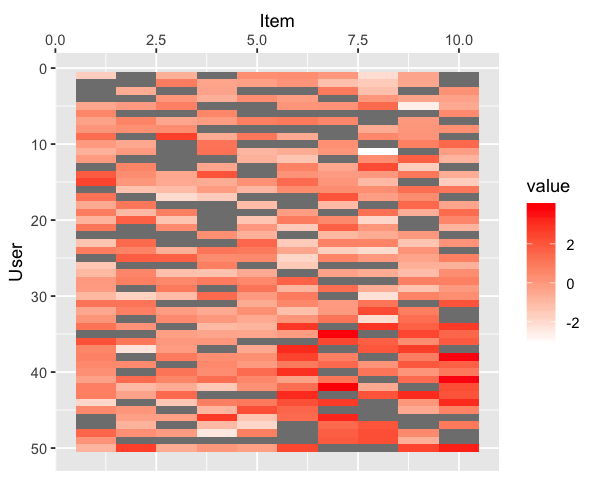

In [19]:

R.plot <- ggplot(melt(R), aes(x = Var2, y = Var1, fill = value)) + geom_tile() +
            scale_fill_continuous(low = "white", high = "red") +
               xlab("Item") + ylab("User") + scale_y_reverse() +
                    scale_x_continuous(position = "top")

options(repr.plot.width = 5, repr.plot.height = 4)

R.plot


### The gradient descent algorithm 

Gradient descent is an iterative optimisation process where by the vector of parameter estimates is derived using the partial derivatives of a particular cost function.

$$ \boldsymbol{\theta_{n}} = \boldsymbol{\theta_{n-1}} + \Delta g(\boldsymbol{\theta_{n-1}}) $$

Where $n$ denotes the iteration number and $ \boldsymbol{\theta} $ denotes the a length 2 vector of the $i$th, $u$th and $k$th elements of the $\hat{P}$ and $\hat{Q}$ matrices. 

$\Delta g(\boldsymbol{\theta_{n-1}}) $ denotes the vector of partial derivatives of the cost function.

The cost function in this example is simply the squared residual error of the predicted value of the $u$ and $i$th elements of the $R_{n}$ matrix given $\hat{P}_{n-1}$ and $\hat{Q}_{n-1}$.  This can be defined as:

$$\epsilon^{2}_{ui} = (R_{ui} - \tilde{R}_{ui})^2$$

Therefore gradient function $\Delta g(\boldsymbol{\theta_{n-1}})$ can be defined as:


\begin{equation*}
g(\boldsymbol{\theta}) = \begin{vmatrix}
\frac{\partial \epsilon^{2}_{ui}}{\partial \hat{P}_{if}} \\
\frac{\partial \epsilon^{2}_{ui}}{\partial \hat{Q}_{if}}
\end{vmatrix}
\end{equation*}

The stochastic gradient descent algorithm loops through each feature and then each element of the $R$ and $Q$ matrices.

For $f = 1....k$
    
> For $R_{ui}$ $u = 1....u$ and $i = 1....i$
>> Calculate $R_{ui} ~ \mid ~ \hat{P} ~ and ~ \hat{Q}$
>>> Update $P_{uf}$ and $Q_{uf}$ 


Let $S(u, i)$ denote $\tilde{R}_{ui}$. The function $S(u, i)$ can be defined as:

$$ S(u, i) = \sum_{f = 1}^k P_{uf} Q_{if} $$

In [20]:

sui <- function(user, item, P.hat, Q.hat, tf) {
  
  v <- rep(as.numeric(NA), tf)
  
  for (f in 1:tf) {
    
    v[f] <- P.hat[user, f] * Q.hat[item, f]
    
  }
  
  s <- sum(v)
  
  return(s)
  
}


Given that $\epsilon_{ui}$ and be defined as $R_{ui} - S(u, i)$, the $g(\boldsymbol{\theta})$ partial derivatives can be defined as:

$$ \Delta Q_{if} = \lambda ( \epsilon_{ui} \hat{P}_{uf} - \gamma \hat{Q}_{if} ) $$

and 

$$ \Delta P_{uf} = \lambda ( \epsilon_{ui} \hat{Q}_{if} - \gamma \hat{P}_{uf} ) $$

Where $\lambda$ denotes the learning rate and $\gamma$ denotes the regularisation parameter.

In [21]:

diff_qif <- function(user, item, feat, eui, P.hat, Q.hat, lambda, gamma) {
  
  lambda * ((eui * P.hat[user, feat]) - (gamma * Q.hat[item, feat]))
  
}

diff_puf <- function(user, item, feat, eui, P.hat, Q.hat, lambda, gamma) {
  
  lambda * ((eui * Q.hat[item, feat]) - (gamma * P.hat[user, feat]))
  
}


We also need to define functions for $P$ and $Q$ that initialise a matrix.  

The matrix can contain any non-zero values, in this instance they'll populate a matrix of value from random normal from a $N(0.1, 0.1^2)$ distribution.

In [22]:

initialise_P <- function(tu, tf) {matrix(rnorm(tu * tf, 0.1, 0.1), tu, tf)}

initialise_Q <- function(ti, tf) {matrix(rnorm(ti * tf, 0.1, 0.1), ti, tf)}
  

Define the gradient descent algorithm:


In [23]:

diy_funk_svd <- function(R, total.features =  NULL, lambda = 0.001, gamma = 0) {
  
  # Determine dimensions 
  
  tf <- if(is.null(total.features)) {ncol(R)} else {total.features}
  
  tu <- nrow(R)
  
  ti <- ncol(R)

  # Initialise P.hat and Q.hat

  P.hat <- initialise_P(tu, tf)

  Q.hat <- initialise_Q(ti, tf)

  # Define SSE matrix

  sse.mat <- matrix(rep(as.numeric(NA), 10000 * tf), 10000, tf)

  # Train each feature

  for (feat in 1:tf) {

    # Run a max of 10000 epochs

    for (i in 1:10000) { 
  
      # If the residual error is the same to 4 dp in two epochs break the loop
  
      if(i > 10) {if(round(sse.mat[i - 1, feat], 4) == round(sse.mat[i - 2, feat], 4)) {break}}

      # Run an epoch

      # Define error matrix
  
      err.mat <- matrix(rep(as.numeric(NA), tu * ti), tu, ti)   
  
        for (user in 1:tu) {
    
          for (item in 1:ti) {
      
            # Skip loop if the element is empty
      
            if(is.na(R[user, item])) {next}
      
            # Get actual rating
  
            rui <- R[user, item]

            # Predict rating based on current P and Q matrices
      
            sui.tilde <- sui(user, item, P.hat, Q.hat, tf)
      
            # Calculate error
      
            eui <- rui - sui.tilde
      
            # Populate error matrix
      
            err.mat[user, item] <- eui^2
      
            # Calculate update values
      
            diff.qif <- diff_qif(user, item, feat, eui, P.hat, Q.hat, lambda, gamma)
      
            diff.puf <- diff_puf(user, item, feat, eui, P.hat, Q.hat, lambda, gamma)
      
            # Update elements of Q.hat and P.hat
      
            Q.hat[item, feat] <- Q.hat[item, feat] + diff.qif
      
            P.hat[user, feat] <- P.hat[user, feat] + diff.puf
      
            }
    
          }
  
        # Calculate SSE for epoch and commit to SSE matrix
  
        sse.mat[i, feat] <- sum(err.mat, na.rm = TRUE)
  
      }
  
    }

  return(list(P.hat = P.hat,
              Q.hat = Q.hat,
              sse = sse.mat))
  
  }


Let's run this example:

In [24]:

example.1 <- diy_funk_svd(R)


We can plot the descent for each feature:

In [25]:

plot_gradient_descent <- function(funk.object) { 

  d <- melt(funk.object$sse)
  
  names(d) <- c("Epoch", "Feature", "SSE")

  d <- na.omit(d)
  
  ggplot(d, aes(x = Epoch, y = SSE)) + geom_line() +
    facet_wrap(~ Feature, scales = "free") +
      ggtitle("Gradient descent per feature") +
         theme(axis.text.x = element_text(angle = 45, hjust = 1))
  
  }


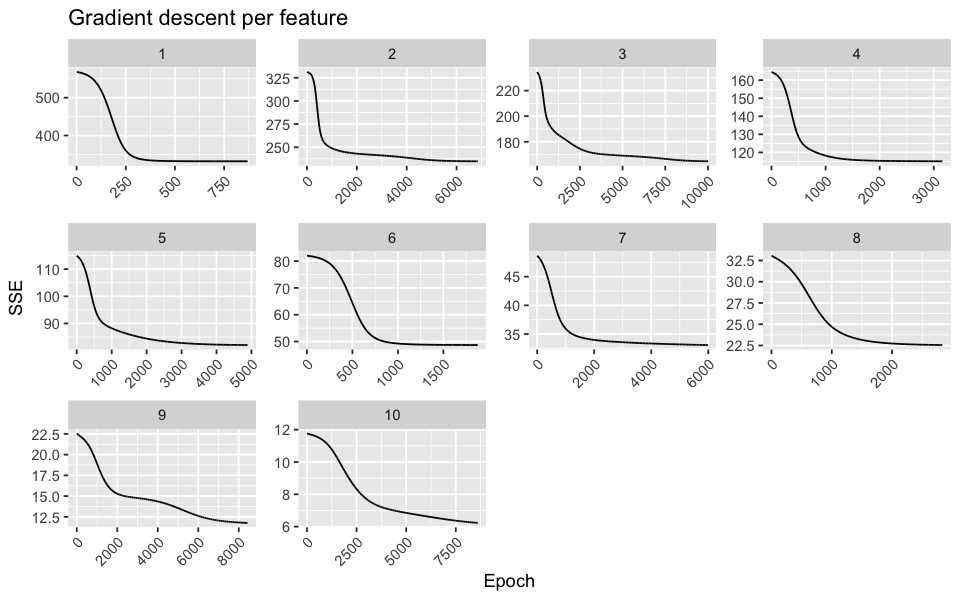

In [26]:

options(repr.plot.width = 8, repr.plot.height = 5)

plot_gradient_descent(example.1)


Finally we can reconstruct the $R$ matrix using the fitted $\hat{P}$ and $\hat{Q}$ matrices.

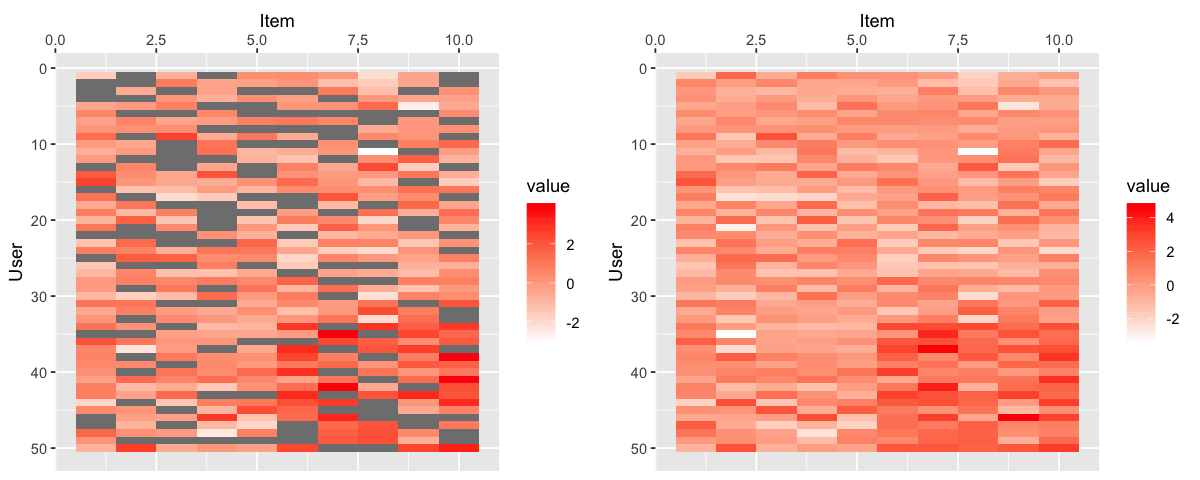

In [27]:

R.tilde <- example.1$P.hat %*% t(example.1$Q.hat)

R.tilde.plot <- ggplot(melt(R.tilde), aes(x = Var2, y = Var1, fill = value)) + 
                    geom_tile() +
                        scale_fill_continuous(low = "white", high = "red") +
                            xlab("Item") + ylab("User") + scale_y_reverse() +
                                scale_x_continuous(position = "top")

options(repr.plot.width = 10, repr.plot.height = 4)

grid.arrange(R.plot, R.tilde.plot, nrow = 1)


Finally we can assess how well the Funk SVD predicted the elements of the $R$ matrix, both sparse and non-sparse.

In [28]:

# How well did it predict the non-sparse elements?

assess_non_sparse <- function(R, R.tilde, Tm) {
  
  non.na.elements <- melt(R)[is.na(melt(R)$value) == FALSE,][, 1:2]

  R.true <- rep(as.numeric(NA), nrow(non.na.elements))
  R.pred <- rep(as.numeric(NA), nrow(non.na.elements))
  R.type <- rep(as.numeric(NA), nrow(non.na.elements))
  
  for (i in 1:nrow(non.na.elements)) {
    
    R.true[i] <- R[non.na.elements$Var1[i], non.na.elements$Var2[i]]

    R.pred[i] <- R.tilde[non.na.elements$Var1[i], non.na.elements$Var2[i]]
    
    R.type[i] <- Tm[non.na.elements$Var1[i], non.na.elements$Var2[i]]  
    
  }
  
  perf <- data.frame(cbind(R.true, R.pred, R.type))
  perf$R.type <- factor(perf$R.type, levels = c("0", "1"))
  
  p <- ggplot(perf, aes(x = R.pred, y = R.true, col = R.type)) + 
        geom_point() +
          xlab("Non-sparse element prediction") + 
            ylab("Non-sparse element value")
  
  sse <- sum((R.pred - R.true)^2)  
  
  return(list(pplot = p,
              sse = sse))
  
  }  
    
# How well did it predict the sparse elements?
  
assess_sparse <- function(R, R.backup, R.tilde, Tm) {

  na.elements <- melt(R)[is.na(melt(R)$value),][, 1:2]

  R.true <- rep(as.numeric(NA), nrow(na.elements))
  R.pred <- rep(as.numeric(NA), nrow(na.elements))
  R.type <- rep(as.numeric(NA), nrow(na.elements))
  
  for (i in 1:nrow(na.elements)) {
    
    R.true[i] <- R.backup[na.elements$Var1[i], na.elements$Var2[i]]
  
    R.pred[i] <- R.tilde[na.elements$Var1[i], na.elements$Var2[i]]
  
    R.type[i] <- Tm[na.elements$Var1[i], na.elements$Var2[i]]  
    
    }
  

  perf <- data.frame(cbind(R.true, R.pred, R.type))
  perf$R.type <- factor(perf$R.type, levels = c("0", "1"))
  
  p <- ggplot(perf, aes(x = R.pred, col = R.type, fill = R.type)) +
        geom_histogram(alpha = 0.3, bins = 10) +
          xlab("Sparse element prediction") + ylab("Density")
  
  sse <- sum((R.pred - R.true)^2)
  
  return(list(pplot = p,
              sse = sse))
  
  }


Below is the predictive performace of the full feature model:

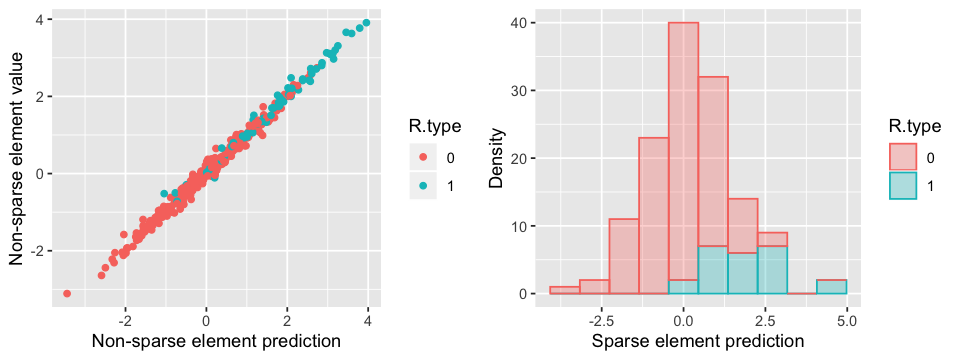

In [29]:
# Let's look at the full feature model

options(repr.plot.width = 8, repr.plot.height = 3)

grid.arrange(assess_non_sparse(R, R.tilde, Tm)$pplot,
             assess_sparse(R, R.backup, R.tilde, Tm)$pplot,
             nrow = 1)

How about a lower feature model?  Here we can train a mode using only two features

In [30]:

example.2 <- diy_funk_svd(R, total.features = 2) 


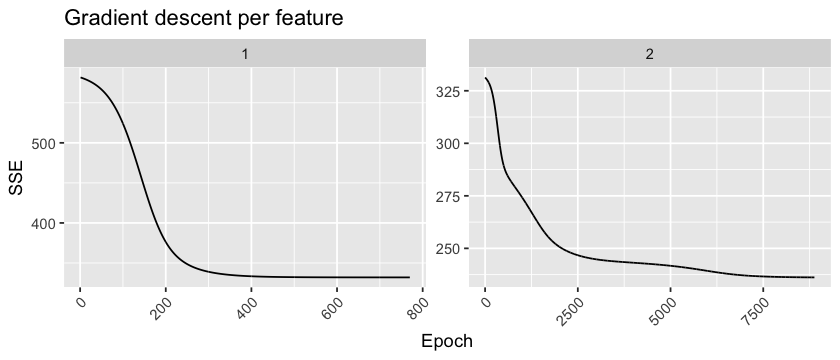

In [31]:

options(repr.plot.width = 7, repr.plot.height = 3)

plot_gradient_descent(example.2)


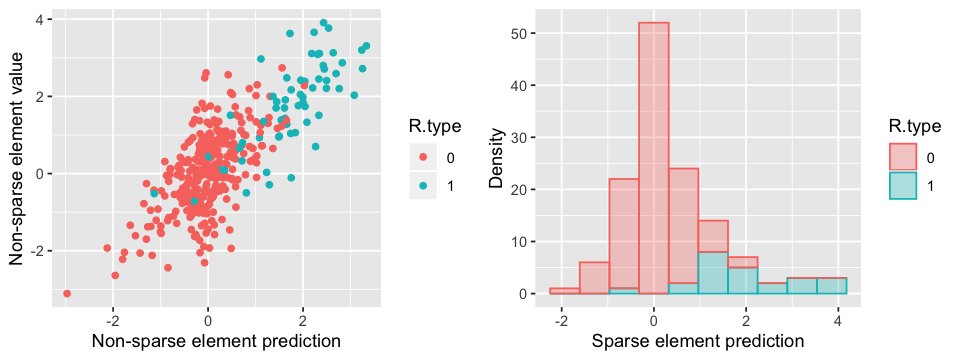

In [32]:

options(repr.plot.width = 8, repr.plot.height = 3)

grid.arrange(assess_non_sparse(R, example.2$P.hat %*% t(example.2$Q.hat), Tm)$pplot,
             assess_sparse(R, R.backup, example.2$P.hat %*% t(example.2$Q.hat), Tm)$pplot,
             nrow = 1)


It can be seen that the non-sparse prediction error is much increased.  However the sparse prediction error (what we actually care about), is another matter:

In [33]:
# Full feature model sparse prediction error:

assess_sparse(R, R.backup, R.tilde, Tm)$sse

[1] 308.0726

In [34]:
# Two feature model sparse prediction error:

assess_sparse(R, R.backup, example.2$P.hat %*% t(example.2$Q.hat), Tm)$sse

[1] 207.1561

It can be seen SSE for the two feature model is actually better than the full feature model, this is because reducing the number of features essentialy acts to reduce the possibility of over-fitting.

### Conclusions

The Funk SVD algorithm is easy to implement even using base R techniques.  Of course dedicated packages can implement these techniques vastly more efficiently. 

This document does not address the issues related to cold start recommendations (e.g. when we have no information for a user) or matters of feature selection.  These can be addressed by imputting additional covariates and cross-validation respectively.